<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/tutorials/tracking_particle_cnn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# DeepTrack 2.0 - Tracking a point particle with a CNN

This tutorial demonstrates how to track a point particle with a convolutional neural network (CNN) using DeepTrack 2.0.

Specifically, this tutotial explains how to: 
* Define the procedure to generate training images
* Extract information from these images to use as labels for the training
* Define and train a neural network model
* Visually evaluate the quality of the neural network output

It is recommended to peruse this tutotial after the [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [1]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particle

For this example, we consider a spherical particle. Specifically, scattering of a spherical particle as determined by mie thery. For this, we use `MieSphere` (see also [scatterers_example](../module-examples/scatterers_example.ipynb)), whose properties are controlled by the following parameters:

* `refractive_index`: The refractive index of the particle

* `radius`: The radius of the marticle

* `position`: The position of the point particle

* `position_unit`: "pixel" or "meter"

In [2]:
mie_particle = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=(32, 32),
    position_unit="pixel",
)

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Optics` (see also [optics_example](../module-examples/optics_example.ipynb)), which takes a set of particles (light scatterers) and convolves them with the pupil function (point spread function) of the optical system. In this tutorial, there is only one light scatterer (here, `mie_particle`).

The optics is controlled by the following parameters:

* `NA`: The numerical aperature

* `resolution`: The effective camera pixel size (m)

* `magnification`: The magnification of the optical device

* `wavelength`: The wavelength of the lightsource (m)

* `output_region`: The position of the camera and the number of pixels (x, y, width_x, width_y)

* `upscale`: upscales all calculations. Increases accuracy at the cost of speed.

In [23]:
IMAGE_SIZE = 64

brightfield_microscope = dt.Brightfield(
    NA=0.9,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(32, 32, 32, 32),
)

## 4. Create and plot the image

To view some object through an optical device, we call the optical device (here, `brightfield_microscope`) with the object we want to image (here, `point_particle`). This creates a new object (here, `imaged_particle`) that can be used to generate the desired image.

The image is finally generated by calling `imaged_particle.resolve()`.

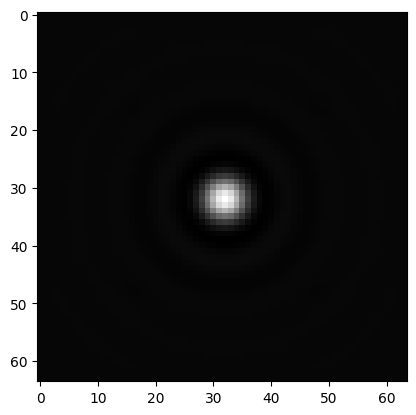

In [24]:
imaged_particle = brightfield_microscope(mie_particle)

output_image = imaged_particle.update().resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

## 5. Randomize the particle position

We can generate particles with random positions by passing to the keyword argument `position` a lambda function that returns a pair of random numbers representing the particle position. We limit the scope, by asserting that the particle is at least 10 pixels from the edge of the image.

We additionally normalize the image to be between 0 and 1. It is very common that normalizing the neural network input improves the results substantially.

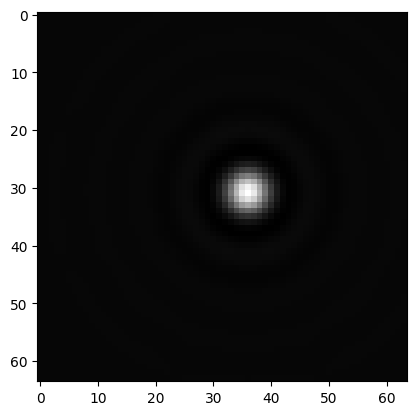

In [25]:
# Generate particle with random position

particle_with_random_position = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=lambda: 10 + np.random.rand(2) * (IMAGE_SIZE - 20),
    position_unit="pixel"
)

imaged_particle_with_random_position = brightfield_microscope(particle_with_random_position)

# Normalize each image between 0 and 1.
normalized_image_of_particle = imaged_particle_with_random_position >> dt.NormalizeMinMax(0, 1) 

output_image = imaged_particle_with_random_position.update().resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')

The position can then be retrieved from the attribute `.position` of the generated image. `.properties` contains a list of all properties used to create the image.

Note that to simulate a particle at a new position, we need to call `.update()`

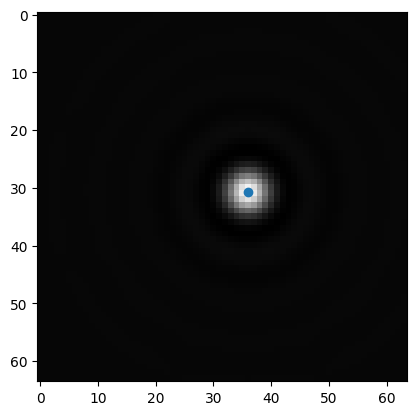

In [26]:


position_of_particle = particle_with_random_position.position()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(position_of_particle[1], position_of_particle[0])
plt.show()

## 6. Define the neural network model

We will use a predefined neural network model obtained by calling the function `convolutional` (see also [models_example](../module-examples/models_example.ipynb)). This model is a convolutional neural network with a dense top. It receives as input an image of shape `(64, 64, 1)` and outputs two scalar values corresponing to the x and y position of the particle.

The model can be customized using the following arguments

* `input_shape`: Size of the images to be analyzed.

* `conv_layers_dimensions`: Number of convolutions in each convolutional layer.
    
* `dense_layers_dimensions`: Number of units in each dense layer.
        
* `number_of_outputs`: Number of units in the output layer.

* `output_activation`: The activation function applied to the output layer.

* `loss`: The loss function of the network.

* `optimizer`: The the optimizer used for training.

* `metrics`: Additional metrics to evaulate during training.

In [27]:
model = dt.models.convolutional(
    input_shape=(64, 64, 1), 
    number_of_outputs=2
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 activation (Activation)     (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                             

## 7. Define image generator

Generators are objects that feed models with images and their corresponging labels during training. They are as instances of the class `ContinuousGenerator` (see also [generators_example](../module-examples/generators_example.ipynb)). This method takes the following inputs:
* `feature`: A feature (see also [features_example](../module-examples/features_example.ipynb) that resolves images used to train a model (here, `imaged_particle_with_random_position`)
* `label_function`: A function that takes an image as input and returns the label for that image (here, `get_position_of_particle`)
* `batch_size`: The number of images per batch
* `min_data_size` The number of images to create starting training
* `max_data_size` The maximum images to hold in memory at one point in time.

In [32]:
# Function that retireves the position of a particle 
# and divides it by 64 to get values between 0 and 1
scaled_position_of_particle = particle_with_random_position.position / IMAGE_SIZE

image_and_position_pipeline = imaged_particle_with_random_position & scaled_position_of_particle

generator = dt.generators.ContinuousGenerator(
    image_and_position_pipeline,
    batch_size=4,
    min_data_size=1024,
    max_data_size=2048
)



In [34]:
validation_size = 256

(validation_data,
 validation_targets) = zip(*[
     image_and_position_pipeline.update().resolve() for _ in range(validation_size) 
])

## 8. Train the model

The model is trained by calling the method `.fit()` with the generator we defined in the previous step. Be patient, this might take some time (several minutes).

If you are training on a CPU, consider reducing the number of epochs to around 50.

In [35]:
with generator:
    model.fit(
        generator,
        epochs=100,
        validation_data=(np.array(validation_data), np.array(validation_targets))
    )

Generating 1054 / 1024 samples before starting training
Epoch 1/100


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.datasets, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.datasets, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/256 [============================>.] - ETA: 0s - loss: 0.0542

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x000002385073CE50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: [WinError 127] Det går inte att hitta den angivna proceduren. Error loading "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\lib\cudnn_adv_infer64_8.dll" or one of its dependencies.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x000002385073CE50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: [WinError 127] Det går inte att hitta den angivna proceduren. Error loading "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\lib\cudnn_adv_infer64_8.dll" or one of its dependencies.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
256/256 [==============================] - 32s 6ms/step - loss: 0.0541 - val_loss: 0.0226
Epoch 2/100
256/256 [==============================] - 2s 6ms/step - loss: 0.0302 - val_loss: 0.0212
Epoch 3/100
256/256 [==============================] - 1s 6ms/ste

## 9. Visualize the model performance

We can now use the trained model to measure the particle position in images previously unseen by the model.

For real applications, it should be noted that the performance can be improved significantly by constraining the particle to be close to the center.

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002387D777BE0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: [WinError 127] Det går inte att hitta den angivna proceduren. Error loading "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\lib\cudnn_adv_infer64_8.dll" or one of its dependencies.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002387D777BE0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: [WinError 127] Det går inte att hitta den angivna proceduren. Error loading "c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\lib\cudnn_adv_infer64_8.dll" or one of its dependencies.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1/1 [==============================] - 0s 122ms/step


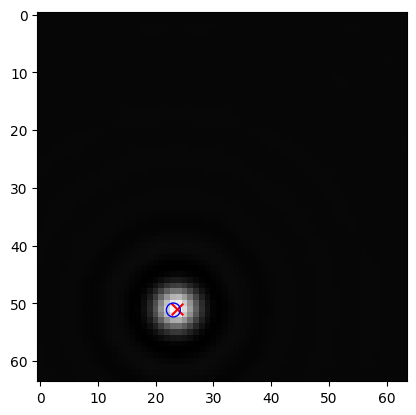

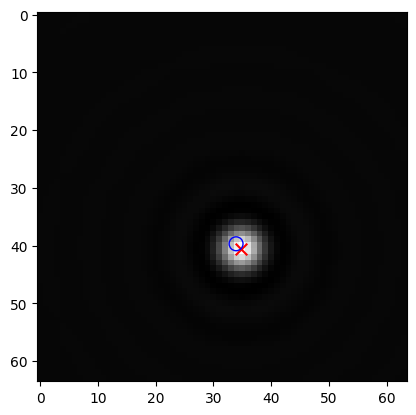

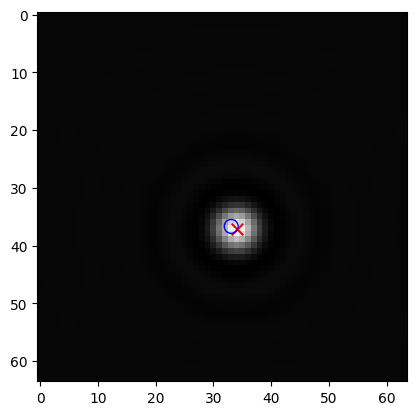

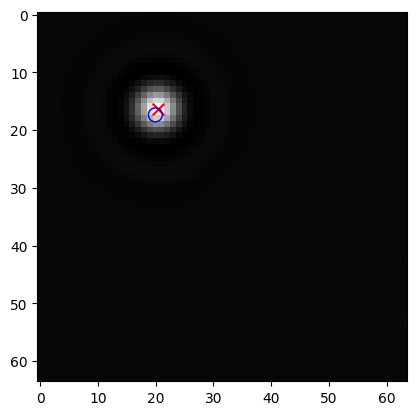

In [36]:
# generator[0] extracts one batch of images from the generator
images, real_positions = generator[0]

measured_positions = model.predict(images)

for i in range(images.shape[0]):
    
    image = np.squeeze(images[i])
    
    measured_position_x = measured_positions[i, 1] * IMAGE_SIZE
    measured_position_y = measured_positions[i, 0] * IMAGE_SIZE

    real_position_x = real_positions[i, 1] * IMAGE_SIZE
    real_position_y = real_positions[i, 0] * IMAGE_SIZE

    plt.imshow(image, cmap='gray')
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='b')
    plt.show()